The dataset we are going to use today is **Boston Dataset**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import random
from sklearn import feature_selection
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing



In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Boston.csv"
BostonData = pd.read_csv(url)
del BostonData['Unnamed: 0']
BostonData.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


The Boston data frame has 506 rows and 14 columns.
Usage

Boston

Format

This data frame contains the following columns:

crim

    per capita crime rate by town 
    
zn

    proportion of residential land zoned for lots over 25,000 sq.ft. 
    
indus

    proportion of non-retail business acres per town 
    
chas

    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
    
nox

    nitrogen oxides concentration (parts per 10 million) 
    
rm

    average number of rooms per dwelling 
    
age

    proportion of owner-occupied units built prior to 1940 
    
dis

    weighted mean of distances to five Boston employment centres 
    
rad

    index of accessibility to radial highways 
    
tax

    full-value property-tax rate per 10,000 dollars
    
ptratio

    pupil-teacher ratio by town 
    
black

    1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
    
lstat

    lower status of the population (percent) 
    
medv

    median value of owner-occupied homes in 1000 dollars

Source

Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.
[Package MASS version 7.2-29 Index]


#### Our goal is to predict the median value of properties (medv) based on other variables in this dataset.

#### First let's draw a scatter-plot of medv and lstat. Intuitively, does it like a pure linear association or it seems like there is some sort of non-linearity?

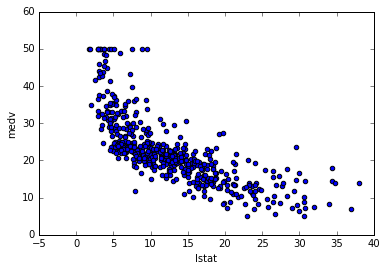

In [3]:
BostonData.plot(kind= 'scatter', x = 'lstat',y = 'medv')

Answer: It seems like there is non-linear association between these two variables. 

#### Now, let's first define few non-linear terms. Start from a pure linear function and go up to polynomial degree 5. 

In [4]:
BostonData['lstat_2'] = BostonData['lstat']**2
BostonData['lstat_3'] = BostonData['lstat']**3
BostonData['lstat_4'] = BostonData['lstat']**4
BostonData['lstat_5'] = BostonData['lstat']**5
X1 = BostonData[['lstat']]
X2 = BostonData[['lstat','lstat_2']]
X3 = BostonData[['lstat','lstat_2','lstat_3']]
X4 = BostonData[['lstat','lstat_2','lstat_3','lstat_4']]
X5 = BostonData[['lstat','lstat_2','lstat_3','lstat_4','lstat_5']]
y = BostonData['medv']


#### Now divide your dataset into 25% test set and 75% training set and use Validation and MSE of test set to decide which degree of polynomial fits the best. Run this procedure a few times!

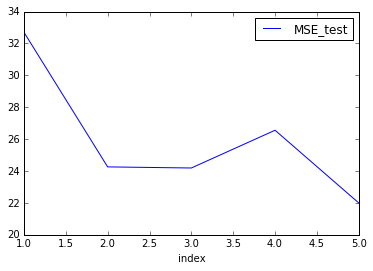

In [5]:
lm = linear_model.LinearRegression()
MSE_test = np.zeros(5)
MSE_train = np.zeros(5)
j = 0
for i in [X1,X2,X3,X4,X5]:
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.25)
    lm.fit(X_train,y_train)
    MSE_test[j] = (metrics.mean_squared_error(lm.predict(X_test),y_test))
    MSE_train[j] = (metrics.mean_squared_error(lm.predict(X_train),y_train))
    j += 1

index = np.array(range(5)) + 1
MSE_Test_df = pd.DataFrame({'MSE_test':MSE_test,'index':index})
MSE_Test_df.plot(x = 'index',y= 'MSE_test')


Answer: It seems the story changes as we run our validation again and again! The reason behind this fact is our small sample size. Validation works best when you have very large sample size. 

#### Now, on the same data set, use 10 fold cross-validation to decide on the degree of polynomial. Justify what you find.

[38.979664071891399, 30.852027340864328, 29.514938916135407, 28.47535829586327, 27.802200537844243]


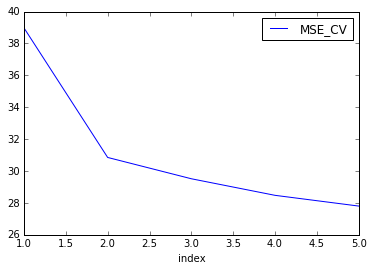

In [6]:
kf = cross_validation.KFold(len(BostonData), n_folds = 10, shuffle = True)
MSE_CV = []

for i in [X1,X2,X3,X4,X5]:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.LinearRegression().fit(i.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index])))
    MSE_CV.append(np.mean(scores))
        
        
print(MSE_CV)
index = np.array(range(5)) + 1
MSE_CV_df = pd.DataFrame({'MSE_CV':MSE_CV,'index':index})
MSE_CV_df.plot(x = 'index',y= 'MSE_CV')

Answer: It seems like our CV error decreases when degrees of freedom increases. The effect is more significant from linear model to quadratic model. After that the slope of error is flatter. CV suggests that we better use at least polynomial degree 2. We can also use polynomial degree 3 if we are not too concerned about the error at the tails of our model. Although, test error is decreasing even for degree 4 and 5, since the gain is not too significant - we prefer to stick to simpler models. 

# Now let's consider more variables.

#### Let's first focus on correlation Matrix.

In [7]:
# Let's first get rid of additional variables we added to our dataframe
del BostonData['lstat_2']
del BostonData['lstat_3']
del BostonData['lstat_4']
del BostonData['lstat_5']

In [8]:
BostonData.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


#### List 3 variables that have the highest chance to appear in your final model - the model that can predict medv. Can these variables appear simultaneously in your final model if your goal is interpretation?

Answer: rm, lstat  ptratio. They are all highly correlated with each other. Specifically, rm and lstat are extremely correlated. So we better not to put all of them simultaneously in our models if we want to use the model for interpretation. 

#### Now let's standardize our data and put it in a new DataFrame called BostonDataNew

In [9]:
BostonDataNew = preprocessing.scale(BostonData) #BostonDataNew is now a numpy array
BostonDataNew = pd.DataFrame(BostonDataNew)   #We changed BostonDataNew to a dataframe
BostonDataNew.columns = BostonData.columns.values

#### Now let's use 10-fold cross validation and Lasso regression on our standardized data to decide which variables to eliminate.

In [10]:
listOfAllVariables = BostonData.columns.values
X = BostonDataNew[listOfAllVariables]
del X['medv']
y = BostonDataNew['medv']

Alpha: 1e-10
Alpha: 1e-09
Alpha: 1e-08
Alpha: 1e-07
Alpha: 1e-06
Alpha: 1e-05
Alpha: 0.0001
Alpha: 0.001
Alpha: 0.01
Alpha: 0.1
Alpha: 1.0
Alpha: 10.0
Alpha: 100.0
Alpha: 1000.0
Alpha: 10000.0
Alpha: 100000.0
Alpha: 1000000.0
Alpha: 10000000.0
Alpha: 100000000.0
Alpha: 1000000000.0
Alpha: 10000000000.0


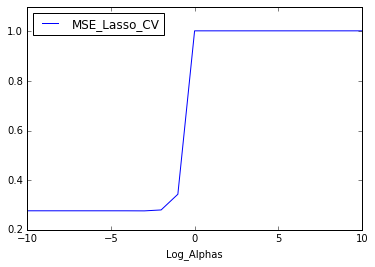

In [11]:
kf = cross_validation.KFold(len(BostonDataNew), n_folds = 10, shuffle = True)
MSE_Lasso_CV = []
alphas = np.logspace(-10, 10, 21)
alphas_index = np.linspace(-10,10,21)
scores = []
for a in alphas:
    print 'Alpha:', a
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Lasso(alpha=a).fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    MSE_Lasso_CV.append(np.mean(scores))



index = alphas
MSE_Lasso_CV_df = pd.DataFrame({'MSE_Lasso_CV': MSE_Lasso_CV ,'Log_Alphas': alphas_index })
MSE_Lasso_CV_df.plot(x = 'Log_Alphas',y = 'MSE_Lasso_CV')

In [12]:
lm = linear_model.Lasso(alpha=10**(-1)) #we could also use -2 but that doesn't give us a clear story.
lm.fit(X, y)
print zip(lm.coef_,X.columns)

[(-0.0, 'crim'), (0.0, 'zn'), (-0.0, 'indus'), (0.0073948593720603436, 'chas'), (-0.0, 'nox'), (0.30018561075517203, 'rm'), (-0.0, 'age'), (-0.0, 'dis'), (-0.0, 'rad'), (-0.0, 'tax'), (-0.15076235514591588, 'ptratio'), (0.026239609395646332, 'black'), (-0.38700973619760293, 'lstat')]


Answer: As expected,'rm', 'ptratio', 'lstat' appeared here. 'chas' and 'black' also have small effect.

#### Now let's use 10-fold cross validation to choose our best model among the following candidates. Let's first add lstat**2 to our model. 

In [13]:
BostonData['lstat_2'] = BostonData['lstat']**2
X1 = BostonData[['lstat']]
X2 = BostonData[['lstat','lstat_2']]
X3 = BostonData[['lstat','chas']]
X4 = BostonData[['lstat','lstat_2','chas']] #'black' is highly correlated with lstat so cannot consider them simoltanously
X5 = BostonData[['ptratio','chas']]
X6 = BostonData[['ptratio','chas','black']]
X7 = BostonData[['ptratio','black']]
X8 = BostonData[['rm']]
X9 = BostonData[['rm','chas']]
X10 = BostonData[['rm','chas','black']]
X11 = BostonData[['rm','black']]
X12 = BostonData[['lstat','ptratio','rm']]  #model without that much interpretability
X13 = BostonData[['lstat','lstat_2','ptratio','rm']]  #model without that much interpretability
X14 = BostonData[['lstat','ptratio','rm','chas','black']]  #model without that much interpretability
X15 = BostonData[['lstat','lstat_2','ptratio','rm','chas','black']]  #model without that much interpretability
y = BostonData['medv']

[38.719504956088024, 30.732896888300179, 37.425426522838599, 29.401180346436114, 62.889101354194828, 57.706277233323419, 58.088713392353725, 44.289318146959999, 43.513099043482825, 38.716257645439377, 39.335792903354076, 27.90604670855398, 23.967983049018891, 26.868373562002994, 22.911319780022858]


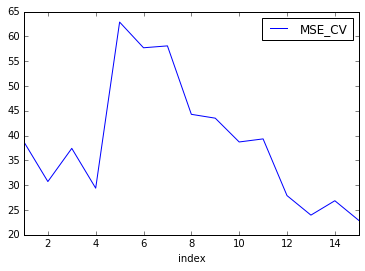

In [14]:
# Use 10 fold cross-validation to decide on the model of your interest

kf = cross_validation.KFold(len(BostonData), n_folds = 10, shuffle = True)
MSE_CV = []

for i in [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15]:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.LinearRegression().fit(i.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index])))
    MSE_CV.append(np.mean(scores))
        
        
print(MSE_CV)
index = np.array(range(15)) + 1
MSE_CV_df = pd.DataFrame({'MSE_CV':MSE_CV,'index':index})
MSE_CV_df.plot(x = 'index',y= 'MSE_CV')

#### If your goal is interpretation - what model(s) are you going to use? Use  smf.ols  in "statsmodels.formula.api as smf" to test significancy of your coefficients. 

Answer: we will most likely use model 2 or 4. If both of these models are significant, then we use model 4. 

In [15]:
for i in [X2,X4]:
    lm1 = smf.ols(formula='y ~ i', data=BostonData).fit()
    print(lm1.summary())
    
# It sounds like both models are highly significant - so we use model 4. lstat, lstat_2 and chas    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Wed, 17 Feb 2016   Prob (F-statistic):          1.56e-112
Time:                        12:12:06   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     42.8620      0.872     49.149      0.0

#### If your goal is prediction - what model(s) are you going to use? Use  smf.ols  in "statsmodels.formula.api as smf" to test significancy of your coefficients. 

Answer: if our goal is prediction, we will most like use models 12, 13, 14 or 15. Let's test to see which one is the best!

In [16]:
for i in [X12,X12,X14,X15]:
    lm1 = smf.ols(formula='y ~ i', data=BostonData).fit()
    print(lm1.summary())
    
    #All of our models are highly significant, so we use model 15. It generates the least CV-MSE. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     353.3
Date:                Wed, 17 Feb 2016   Prob (F-statistic):          2.69e-123
Time:                        12:12:10   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     502   BIC:                             3131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     18.5671      3.913      4.745      0.0